In [1]:
from matplotlib import pyplot as plt
from mxnet import autograd, nd, init, gluon
from mxnet.gluon import data as gdata
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
from time import time
import pandas as pd
import d2lzh as d2l
import random
import sys 

# 03. 深度学习基础

## 3.11 模型选择、⽋拟合和过拟合

### 3.11.1 训练误差和泛化误差
通俗来讲，`训练误差`指模型在训练数据集上表现出的误差，`泛化误差`指模型在任意⼀个测试数据样本上表现出的误差的期望，并常常通过测试数据集上的误差来近似。计算训练误差和泛化误差可以使⽤之前介绍过的损失函数，例如线性回归⽤到的`平⽅损失函数`和softmax回归⽤到的`交叉熵损失函数`。

在机器学习⾥，我们通常假设`训练数据集`和`测试数据集`⾥的每⼀个样本都是从同⼀个概率分布中相互独⽴地⽣成的。基于该独⽴同分布假设，给定任意⼀个机器学习模型 (含参数)，它的训练误差的期望和泛化误差都是⼀样的。例如，如果我们将模型参数设成随机值，那么训练误差和泛化误差会⾮常相近。但我们从前⾯⼏节中已经了解到，模型的参数是通过在训练数据集上训练模型而学习出的，参数的选择依据了最小化训练误差。 所以，训练误差的期望小于或等于泛化误差。也就是说，⼀般情况下，由训练数据集学到的模型参数会使模型在训练数据集上的表现优于或等于在测试数据集上的表现。由于⽆法从训练误差估计泛化误差，⼀味地降低训练误差并不意味着泛化误差⼀定会降低。

机器学习模型应关注降低泛化误差。

### 3.11.2 模型选择
在机器学习中， 通常需要评估若⼲候选模型的表现并从中选择模型。 这⼀过程称为`模型选择`。可供选择的候选模型可以是有着不同超参数的同类模型。以多层感知机为例，我们可以选择隐藏层的个数，以及每个隐藏层中隐藏单元个数和激活函数。为了得到有效的模型，我们通常要在模型选择上下⼀番功夫。

下⾯，我们来描述模型选择中经常使⽤的`验证数据集`。

##### 验证数据集
从严格意义上讲，测试集只能在所有超参数和模型参数选定后使⽤⼀次。不可以使⽤测试数据选择模型，如调参。由于⽆法从训练误差估计泛化误差，因此也不应只依赖训练数据选择模型。鉴于此，我们可以预留⼀部分在训练数据集和测试数据集以外的数据来进⾏模型选择。这部分数据被称为`验证数据集`。例如，我们可以从给定的训练集中随机选取⼀小部分作为验证集，而将剩余部分作为真正的训练集。

然而在实际应⽤中，由于数据不容易获取，测试数据极少只使⽤⼀次就丢弃。因此，实践中验证数据集和测试数据集的界限可能⽐较模糊。从严格意义上讲，除⾮明确说明，否则本书中实验所使⽤的测试集应为验证集，实验报告的测试结果(如测试准确率)应为验证结果(如验证准确率)。

##### K折交叉验证
由于验证数据集不参与模型训练，当训练数据不够⽤时，预留⼤量的验证数据显得太奢侈。⼀种改善的⽅法是`K折交叉验证`。在K折交叉验证中，我们把原始训练数据集分割成K个不重合的⼦数据集，然后我们做K次模型训练和验证。每⼀次，我们使⽤⼀个⼦数据集验证模型，并使⽤其他`K-1`个⼦数据集来训练模型。在这K次训练和验证中，每次⽤来验证模型的⼦数据集都不同。最后，我们对这K次训练误差和验证误差分别求平均。

### 3.11.3 ⽋拟合和过拟合
模型训练中经常出现的两类典型问题：
+ ⼀类是模型⽆法得到较低的训练误差， 我们将这⼀现象称作`⽋拟合`(underfitting)
+ ⼀类是模型的训练误差远小于它在测试数据集上的误差，我们称该现象为`过拟合`(overfitting)

在实践中，我们要尽可能同时应对⽋拟合和过拟 合。虽然有很多因素可能导致这两种拟合问题，在这⾥我们重点讨论两个因素：模型复杂度和训练数据集⼤小。

##### 模型复杂度
为了解释模型复杂度，我们以多项式函数拟合为例。给定⼀个由标量数据特征$x$和对应的标量标签$y$组成的训练数据集，多项式函数拟合的⽬标是找⼀个$K$阶多项式函数
+ $\displaystyle\hat{y} = b + \sum_{k=1}^K x^k w_k$

来近似$y$。在上式中，$w_k$是模型的权重参数，$b$是偏差参数。与线性回归相同，多项式函数拟合也使用平方损失函数。特别地，一阶多项式函数拟合又叫线性函数拟合。

因为高阶多项式函数模型参数更多，模型函数的选择空间更大，所以高阶多项式函数比低阶多项式函数的复杂度更高。因此，高阶多项式函数比低阶多项式函数更容易在相同的训练数据集上得到更低的训练误差。给定训练数据集，模型复杂度和误差之间的关系通常如`图3.4`所示。给定训练数据集，如果模型的复杂度过低，很容易出现欠拟合；如果模型复杂度过高，很容易出现过拟合。应对欠拟合和过拟合的一个办法是针对数据集选择合适复杂度的模型。

<img src="images/03_04.png" style="width:400px;"/>

##### 训练数据集⼤⼩
⼀般来说，如果训练数据集中样本数过少，特别是⽐模型参数数量更少时，过拟合更容易发⽣。此外，泛化误差不会随训练数据集⾥样本数量增加而增⼤。因此，在计算资源允许的范围之内，我们通常希望训练数据集⼤⼀些，特别是在模型复杂度较⾼时。

### 3.11.4 多项式函数拟合实验

##### ⽣成数据集
我们将生成一个人工数据集。在训练数据集和测试数据集中，给定样本特征$x$，我们使用如下的三阶多项式函数来生成该样本的标签：
+ $y = 1.2x - 3.4x^2 + 5.6x^3 + 5 + \epsilon$

其中噪声项$\epsilon$服从均值为0、标准差为0.1的正态分布。训练数据集和测试数据集的样本数都设为100。

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5 

features = nd.random.normal(shape=(n_train + n_test, 1)) 
poly_features = nd.concat(features, nd.power(features, 2), nd.power(features, 3))
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1] + true_w[2] * poly_features[:, 2] + true_b) 
labels += nd.random.normal(scale=0.1, shape=labels.shape)

features[:2], poly_features[:2], labels[:2]

(
 [[2.2122064]
  [0.7740038]]
 <NDArray 2x1 @cpu(0)>, 
 [[ 2.2122064   4.893857   10.826221  ]
  [ 0.7740038   0.5990819   0.46369165]]
 <NDArray 2x3 @cpu(0)>, 
 [51.674885   6.3585763]
 <NDArray 2 @cpu(0)>)

##### 定义、训练和测试模型
我们先定义作图函数`semilogy`，其中`y`轴使⽤了对数尺度。

In [3]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(5, 4)):
    d2l.set_figsize(figsize) 
    plt.xlabel(x_label) 
    plt.ylabel(y_label) 
    plt.semilogy(x_vals, y_vals) 
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':') 
        plt.legend(legend)
        plt.show()

多项式函数拟合也使⽤平⽅损失函数。我们尝试使⽤不同复杂度的模型来拟合⽣成的数据集，我们把模型定义部分放在`fit_and_plot`函数中。

In [4]:
num_epochs, loss = 100, gloss.L2Loss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential() 
    net.add(nn.Dense(1)) 
    net.initialize() 
    batch_size = min(10, train_labels.shape[0]) 
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True) 
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01}) 
    train_ls, test_ls = [], [] 
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y) 
            l.backward() 
            trainer.step(batch_size) 
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar()) 
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar()) 
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1]) 
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test']) 
    print('weight:', net[0].weight.data().asnumpy(), '\nbias:', net[0].bias.data().asnumpy())

##### 三阶多项式函数拟合(正常)
我们先使⽤与数据⽣成函数同阶的三阶多项式函数拟合。实验表明，这个模型的训练误差和在测试数据集的误差都较低。训练出的模型参数也接近真实值：

final epoch: train loss 0.007006191 test loss 0.011435781


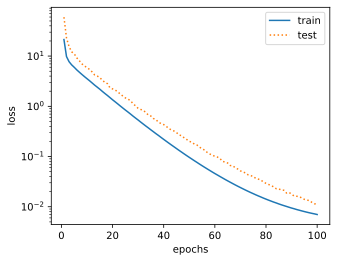

weight: [[ 1.3249168 -3.3632596  5.5630836]] 
bias: [4.9516664]


In [5]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

##### 线性函数拟合(⽋拟合)
我们再试试线性函数拟合。很明显，该模型的训练误差在迭代早期下降后便很难继续降低。在完成最后⼀次迭代周期后，训练误差依旧很⾼。线性模型在⾮线性模型(如三阶多项式函数)⽣成的数据集上容易⽋拟合。

final epoch: train loss 43.997635 test loss 160.7767


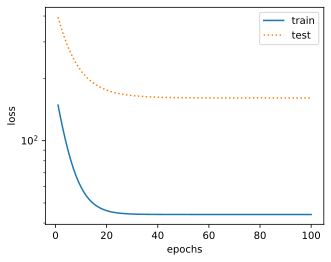

weight: [[15.559458]] 
bias: [2.2870123]


In [6]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

##### 训练样本不⾜(过拟合)
事实上，即便使⽤与数据⽣成模型同阶的三阶多项式函数模型，如果训练样本不⾜，该模型依然容易过拟合。让我们只使⽤两个样本来训练模型。显然，训练样本过少了，甚⾄少于模型参数的数量，这使模型显得过于复杂，以⾄于容易被训练数据中的噪声影响。在迭代过程中，尽管训练误差较低，但是测试数据集上的误差却很⾼。这是典型的过拟合现象。

final epoch: train loss 0.4027369 test loss 103.31421


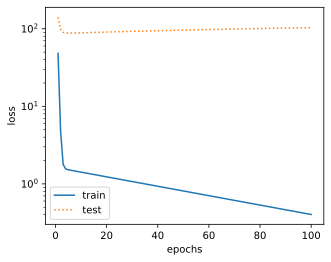

weight: [[1.3872364 1.9376589 3.5085924]] 
bias: [1.2312856]


In [7]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])

## 3.12 权重衰减
本节介绍应对过拟合问题的常⽤⽅法：`权重衰减`。

### 3.12.1 ⽅法
权重衰减等价于$L_2$范数正则化。

$L_2$范数正则化在模型原损失函数基础上添加$L_2$范数惩罚项，从而得到训练所需要最小化的函数。$L_2$范数惩罚项指的是模型权重参数每个元素的平方和与一个正的常数的乘积。以`线性回归`一节中的线性回归损失函数

+ $\displaystyle\ell(w_1, w_2, b) = \frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right)^2$

为例，其中$w_1, w_2$是权重参数，$b$是偏差参数，样本$i$的输入为$x_1^{(i)}, x_2^{(i)}$，标签为$y^{(i)}$，样本数为$n$。将权重参数用向量$\boldsymbol{w} = [w_1, w_2]$表示，带有$L_2$范数惩罚项的新损失函数为

+ $\ell(w_1, w_2, b) + \frac{\lambda}{2n} |\boldsymbol{w}|^2$

其中超参数$\lambda > 0$。当权重参数均为0时，惩罚项最小。当$\lambda$较大时，惩罚项在损失函数中的比重较大，这通常会使学到的权重参数的元素较接近0。当$\lambda$设为0时，惩罚项完全不起作用。

上式中$L_2$范数平方$|\boldsymbol{w}|^2$展开后得到$w_1^2 + w_2^2$。有了$L_2$范数惩罚项后，在小批量随机梯度下降中，我们将`线性回归`一节中权重$w_1$和$w_2$的迭代方式更改为

$$\displaystyle \begin{aligned} w_1 &\leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right)w_1 - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_1^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right),\\ w_2 &\leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right)w_2 - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_2^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right)\end{aligned} $$

可见，$L_2$范数正则化令权重$w_1$和$w_2$先自乘小于1的数，再减去不含惩罚项的梯度。因此，$L_2$范数正则化又叫权重衰减。权重衰减通过惩罚绝对值较大的模型参数为需要学习的模型增加了限制，这可能对过拟合有效。实际场景中，我们有时也在惩罚项中添加偏差元素的平方和。

### 3.12.2 ⾼维线性回归实验
我们以高维线性回归为例来引入一个过拟合问题，并使用权重衰减来应对过拟合。

设数据样本特征的维度为$p$。对于训练数据集和测试数据集中特征为$x_1, x_2, \ldots, x_p$的任一样本，我们使用如下的线性函数来生成该样本的标签：
+ $\displaystyle y = 0.05 + \sum_{i = 1}^p 0.01x_i + \epsilon$

其中噪声项$\epsilon$服从均值为0、标准差为0.01的正态分布。为了较容易地观察过拟合，我们考虑高维线性回归问题，如设维度$p=200$；同时，我们特意把训练数据集的样本数设低，如20。

In [8]:
n_train, n_test, num_inputs = 20, 100, 200 

true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape=(n_train + n_test, num_inputs)) 

labels = nd.dot(features, true_w) + true_b 
labels += nd.random.normal(scale=0.01, shape=labels.shape) 

train_features, test_features = features[:n_train, :], features[n_train:, :] 
train_labels, test_labels = labels[:n_train], labels[n_train:]

### 3.12.3 从零开始实现
下⾯先介绍从零开始实现权重衰减的⽅法。

##### 初始化模型参数
定义随机初始化模型参数的函数。该函数为每个参数都附上梯度。

In [9]:
def init_params():
    w = nd.random.normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,)) 
    w.attach_grad() 
    b.attach_grad() 
    return [w, b]

##### 定义L2范数惩罚项
这⾥只惩罚模型的权重参数。

In [10]:
def l2_penalty(w):
    return (w**2).sum()/2

##### 定义训练和测试
下⾯定义如何在训练数据集和测试数据集上分别训练和测试模型。我们在计算最终的损失函数时添加了$L_2$范数惩罚项。

In [11]:
batch_size, num_epochs, lr = 1, 100, 0.003

net, loss = d2l.linreg, d2l.squared_loss 

train_iter = gdata.DataLoader(gdata.ArrayDataset( train_features, train_labels), batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params() 
    train_ls, test_ls = [], [] 
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                # 添加了L2范数惩罚项 
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test']) 
    print('L2 norm of w:', w.norm().asscalar())

##### 观察过拟合
训练并测试⾼维线性回归模型。当lambd设为0时，我们没有使⽤权重衰减，模型产生了过拟合现象。

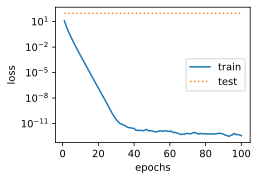

L2 norm of w: 14.538621


In [12]:
fit_and_plot(lambd=0)

##### 使⽤权重衰减
下⾯我们使⽤权重衰减。可以看出，训练误差虽然有所提⾼，但测试集上的误差有所下降。过拟合现象得到⼀定程度的缓解。另外，权重参数的$L_2$范数⽐不使⽤权重衰减时的更小，此时的权重参数更接近0。

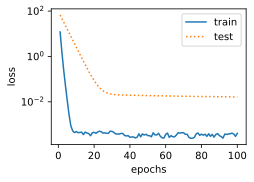

L2 norm of w: 0.036223266


In [13]:
fit_and_plot(lambd=3)

### 3.12.4 简洁实现
我们可以直接在构造Trainer实例时通过`wd`参数来指定权重衰减超参数。默认下，Gluon会对权重和偏差同时衰减。我们可以分别对权重和偏差构造Trainer实例，从而只对权重衰减。

In [14]:
def fit_and_plot_gluon(wd):
    net = nn.Sequential() 
    net.add(nn.Dense(1)) 
    net.initialize(init.Normal(sigma=1)) 
    # 对权重参数衰减。权重名称⼀般是以weight结尾
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd', {'learning_rate': lr, 'wd': wd}) 
    # 不对偏差参数衰减。偏差名称⼀般是以bias结尾
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd', {'learning_rate': lr}) 
    train_ls, test_ls = [], [] 
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y) 
            l.backward() 
            # 对两个Trainer实例分别调⽤step函数，从⽽分别更新权重和偏差 
            trainer_w.step(batch_size) 
            trainer_b.step(batch_size) 
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar()) 
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test']) 
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

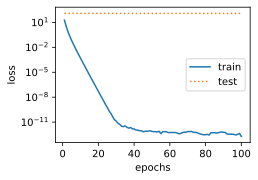

L2 norm of w: 13.921219


In [15]:
fit_and_plot_gluon(0)

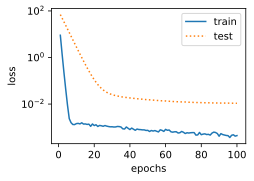

L2 norm of w: 0.04367591


In [16]:
fit_and_plot_gluon(3)

## 3.13 丢弃法
深度学习模型也常常使用`丢弃法`(dropout)来应对过拟合问题。丢弃法有一些不同的变体，本节中提到的丢弃法特指`倒置丢弃法`(inverted dropout)。

### 3.13.1 ⽅法
回忆一下，`图3.3`描述了一个单隐藏层的多层感知机。其中输入个数为4，隐藏单元个数为5，且隐藏单元$h_i$（$i=1, \ldots, 5$）的计算表达式为
+ $h_i = \phi\left(x_1 w_{1i} + x_2 w_{2i} + x_3 w_{3i} + x_4 w_{4i} + b_i\right)$

这里$\phi$是激活函数，$x_1, \ldots, x_4$是输入，隐藏单元$i$的权重参数为$w_{1i}, \ldots, w_{4i}$，偏差参数为$b_i$。

当对该隐藏层使用丢弃法时，该层的隐藏单元将有一定概率被丢弃掉。设丢弃概率为$p$， 那么有$p$的概率$h_i$会被清零，有$1-p$的概率$h_i$会除以$1-p$做拉伸。丢弃概率是丢弃法的超参数。具体来说，设随机变量$\xi_i$为0和1的概率分别为$p$和$1-p$。使用丢弃法时我们计算新的隐藏单元$h_i'$
+ $h_i' = \frac{\xi_i}{1-p} h_i$

由于$E(\xi_i) = 1-p$，因此
+ $\displaystyle E(h_i') = \frac{E(\xi_i)}{1-p}h_i = h_i$

即丢弃法不改变其输入的期望值。

让我们对`图3.3`中的隐藏层使用丢弃法，一种可能的结果如`图3.5`所示，其中$h_2$和$h_5$被清零。这时输出值的计算不再依赖$h_2$和$h_5$，在反向传播时，与这两个隐藏单元相关的权重的梯度均为0。由于在训练中隐藏层神经元的丢弃是随机的，即$h_1, \ldots, h_5$都有可能被清零，输出层的计算无法过度依赖$h_1, \ldots, h_5$中的任一个，从而在训练模型时起到正则化的作用，并可以用来应对过拟合。

<img src="images/03_05.png" style="width:400px;"/>

在测试模型时，我们为了拿到更加确定性的结果，一般不使用丢弃法。

### 3.13.2 从零开始实现
根据丢弃法的定义，我们可以很容易地实现它。下⾯的`dropout`函数将以`drop_prob`的概率丢弃NDArray输⼊`X`中的元素。

In [17]:
def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1 
    keep_prob = 1 - drop_prob 
    # 这种情况下把全部元素都丢弃 
    if keep_prob == 0:
        return X.zeros_like() 
    mask = nd.random.uniform(0, 1, X.shape) < keep_prob 
    return mask * X / keep_prob

In [18]:
X = nd.arange(16).reshape((2, 8)) 
dropout(X, 0)


[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
<NDArray 2x8 @cpu(0)>

In [19]:
dropout(X, 0.5)


[[ 0.  2.  4.  6.  0. 10.  0.  0.]
 [ 0.  0.  0.  0. 24. 26. 28.  0.]]
<NDArray 2x8 @cpu(0)>

In [20]:
dropout(X, 1)


[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
<NDArray 2x8 @cpu(0)>

##### 定义模型参数
我们依然使⽤Fashion-MNIST数据集。我们将定义⼀个包含两个隐藏层的多层感知机，其中两个隐藏层的输出个数都是256。

In [21]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens1)) 
b1 = nd.zeros(num_hiddens1) 
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens1, num_hiddens2)) 
b2 = nd.zeros(num_hiddens2) 
W3 = nd.random.normal(scale=0.01, shape=(num_hiddens2, num_outputs)) 
b3 = nd.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()

##### 定义模型
下⾯定义的模型将全连接层和激活函数ReLU串起来，并对每个激活函数的输出使⽤丢弃法。我们可以分别设置各个层的丢弃概率。通常的建议是把靠近输⼊层的丢弃概率设得小⼀点。在这个实验中，我们把第⼀个隐藏层的丢弃概率设为0.2，把第⼆个隐藏层的丢弃概率设为0.5。我们可以通过`⾃动求梯度`⼀节中介绍的`is_training`函数来判断运⾏模式为训练还是测试，并只需在训练模式下使⽤丢弃法。

In [22]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X):
    X = X.reshape((-1, num_inputs))
    H1 = (nd.dot(X, W1) + b1).relu() 
    if autograd.is_training(): # 只在训练模型时使⽤丢弃法
        H1 = dropout(H1, drop_prob1) # 在第⼀层全连接后添加丢弃层 
    H2 = (nd.dot(H1, W2) + b2).relu() 
    if autograd.is_training():
        H2 = dropout(H2, drop_prob2) # 在第⼆层全连接后添加丢弃层 
    return nd.dot(H2, W3) + b3

##### 训练和测试模型
这部分与之前多层感知机的训练和测试类似。

In [23]:
num_epochs, lr, batch_size = 5, 0.5, 256

loss = gloss.SoftmaxCrossEntropyLoss() 
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size) 
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 1.1480, train acc 0.557, test acc 0.781
epoch 2, loss 0.5781, train acc 0.786, test acc 0.801
epoch 3, loss 0.4868, train acc 0.821, test acc 0.848
epoch 4, loss 0.4484, train acc 0.837, test acc 0.864
epoch 5, loss 0.4193, train acc 0.847, test acc 0.866


### 3.13.3 简洁实现
在Gluon中，我们只需要在全连接层后添加Dropout层并指定丢弃概率。 在训练模型时，Dropout层将以指定的丢弃概率随机丢弃上⼀层的输出元素；在测试模型时，Dropout层并不发挥作⽤。

In [24]:
net = nn.Sequential()

net.add(nn.Dense(256, activation="relu"), 
    nn.Dropout(drop_prob1), # 在第⼀个全连接层后添加丢弃层
    nn.Dense(256, activation="relu"), # 在第⼆个全连接层后添加丢弃层
    nn.Dropout(drop_prob2), 
    nn.Dense(10)) 
net.initialize(init.Normal(sigma=0.01))

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, trainer)

epoch 1, loss 1.1837, train acc 0.546, test acc 0.783
epoch 2, loss 0.6010, train acc 0.775, test acc 0.831
epoch 3, loss 0.5009, train acc 0.816, test acc 0.847
epoch 4, loss 0.4657, train acc 0.830, test acc 0.852
epoch 5, loss 0.4301, train acc 0.843, test acc 0.865


## 3.14 正向传播、反向传播和计算图
我们使⽤了小批量随机梯度下降的优化算法来训练模型。在实现中，我们只提供了模型的`正向传播`的计算，即对输⼊计算模型输出，然后通过`autograd`模块 来调⽤系统⾃动⽣成的`backward`函数计算梯度。

基于`反向传播`算法的⾃动求梯度极⼤简化了深度学习模型训练算法的实现。本节我们将使⽤数学和计算图两个⽅式来描述正向传播和反向传播。具体来说，我们将以带$L_2$范数正则化的含单隐藏层的多层感知机为样例模型解释正向传播和反向传播。

### 3.14.1 正向传播
正向传播是指对神经网络沿着从输入层到输出层的顺序，依次计算并存储模型的中间变量(包括输出)。为简单起见，假设输入是一个特征为$\boldsymbol{x} \in \mathbb{R}^d$的样本，且不考虑偏差项，那么中间变量

+ $\boldsymbol{z} = \boldsymbol{W}^{(1)} \boldsymbol{x}$

其中$\boldsymbol{W}^{(1)} \in \mathbb{R}^{h \times d}$是隐藏层的权重参数。把中间变量$\boldsymbol{z} \in \mathbb{R}^h$输入按元素运算的激活函数$\phi$后，将得到向量长度为$h$的隐藏层变量
+ $\boldsymbol{h} = \phi (\boldsymbol{z})$

隐藏层变量$\boldsymbol{h}$也是一个中间变量。假设输出层参数只有权重$\boldsymbol{W}^{(2)} \in \mathbb{R}^{q \times h}$，可以得到向量长度为$q$的输出层变量
+ $\boldsymbol{o} = \boldsymbol{W}^{(2)} \boldsymbol{h}$

假设损失函数为$\ell$，且样本标签为$y$，可以计算出单个数据样本的损失项
+ $L = \ell(\boldsymbol{o}, y)$

根据$L_2$范数正则化的定义，给定超参数$\lambda$，正则化项即
+ $s = \frac{\lambda}{2} \left(|\boldsymbol{W}^{(1)}|_F^2 + |\boldsymbol{W}^{(2)}|_F^2\right)$

其中矩阵的Frobenius范数等价于将矩阵变平为向量后计算$L_2$范数。最终，模型在给定的数据样本上带正则化的损失为
+ $J = L + s$

我们将$J$称为有关给定数据样本的目标函数，并在以下的讨论中简称目标函数。

### 3.14.2 正向传播的计算图
我们通常绘制计算图来可视化运算符和变量在计算中的依赖关系。`图3.6`绘制了本节中样例模型正向传播的计算图，其中左下⻆是输⼊，右上⻆是输出。可以看到，图中箭头⽅向⼤多是向右和向上，其中⽅框代表变量，圆圈代表运算符，箭头表⽰从输⼊到输出之间的依赖关系。

<img src="images/03_06.png" style="width:500px;"/>

### 3.14.3 反向传播
反向传播指的是计算神经网络参数梯度的方法。总的来说，反向传播依据微积分中的链式法则，沿着从输出层到输入层的顺序，依次计算并存储目标函数有关神经网络各层的中间变量以及参数的梯度。对输入或输出$\mathsf{X}, \mathsf{Y}, \mathsf{Z}$为任意形状张量的函数$\mathsf{Y}=f(\mathsf{X})$和$\mathsf{Z}=g(\mathsf{Y})$，通过链式法则，我们有

$$\frac{\partial \mathsf{Z}}{\partial \mathsf{X}} = \text{prod}\left(\frac{\partial \mathsf{Z}}{\partial \mathsf{Y}}, \frac{\partial \mathsf{Y}}{\partial \mathsf{X}}\right),$$

其中$\text{prod}$运算符将根据两个输入的形状，在必要的操作（如转置和互换输入位置）后对两个输入做乘法。

回顾一下本节中样例模型，它的参数是$\boldsymbol{W}^{(1)}$和$\boldsymbol{W}^{(2)}$，因此反向传播的目标是计算$\partial J/\partial \boldsymbol{W}^{(1)}$和$\partial J/\partial \boldsymbol{W}^{(2)}$。我们将应用链式法则依次计算各中间变量和参数的梯度，其计算次序与前向传播中相应中间变量的计算次序恰恰相反。首先，分别计算目标函数$J=L+s$有关损失项$L$和正则项$s$的梯度

$$\frac{\partial J}{\partial L} = 1, \quad \frac{\partial J}{\partial s} = 1.$$

其次，依据链式法则计算目标函数有关输出层变量的梯度$\partial J/\partial \boldsymbol{o} \in \mathbb{R}^q$：

$$ \frac{\partial J}{\partial \boldsymbol{o}} = \text{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \boldsymbol{o}}\right) = \frac{\partial L}{\partial \boldsymbol{o}}. $$

接下来，计算正则项有关两个参数的梯度：

$$\frac{\partial s}{\partial \boldsymbol{W}^{(1)}} = \lambda \boldsymbol{W}^{(1)},\quad\frac{\partial s}{\partial \boldsymbol{W}^{(2)}} = \lambda \boldsymbol{W}^{(2)}.$$

现在，我们可以计算最靠近输出层的模型参数的梯度$\partial J/\partial \boldsymbol{W}^{(2)} \in \mathbb{R}^{q \times h}$。依据链式法则，得到

$$ \frac{\partial J}{\partial \boldsymbol{W}^{(2)}} = \text{prod}\left(\frac{\partial J}{\partial \boldsymbol{o}}, \frac{\partial \boldsymbol{o}}{\partial \boldsymbol{W}^{(2)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \boldsymbol{W}^{(2)}}\right) = \frac{\partial J}{\partial \boldsymbol{o}} \boldsymbol{h}^\top + \lambda \boldsymbol{W}^{(2)}. $$

沿着输出层向隐藏层继续反向传播，隐藏层变量的梯度$\partial J/\partial \boldsymbol{h} \in \mathbb{R}^h$可以这样计算：

$$ \frac{\partial J}{\partial \boldsymbol{h}} = \text{prod}\left(\frac{\partial J}{\partial \boldsymbol{o}}, \frac{\partial \boldsymbol{o}}{\partial \boldsymbol{h}}\right) = {\boldsymbol{W}^{(2)}}^\top \frac{\partial J}{\partial \boldsymbol{o}}. $$

由于激活函数$\phi$是按元素运算的，中间变量$\boldsymbol{z}$的梯度$\partial J/\partial \boldsymbol{z} \in \mathbb{R}^h$的计算需要使用按元素乘法符$\odot$：

$$ \frac{\partial J}{\partial \boldsymbol{z}} = \text{prod}\left(\frac{\partial J}{\partial \boldsymbol{h}}, \frac{\partial \boldsymbol{h}}{\partial \boldsymbol{z}}\right) = \frac{\partial J}{\partial \boldsymbol{h}} \odot \phi'\left(\boldsymbol{z}\right). $$

最终，我们可以得到最靠近输入层的模型参数的梯度$\partial J/\partial \boldsymbol{W}^{(1)} \in \mathbb{R}^{h \times d}$。依据链式法则，得到

$$ \frac{\partial J}{\partial \boldsymbol{W}^{(1)}} = \text{prod}\left(\frac{\partial J}{\partial \boldsymbol{z}}, \frac{\partial \boldsymbol{z}}{\partial \boldsymbol{W}^{(1)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \boldsymbol{W}^{(1)}}\right) = \frac{\partial J}{\partial \boldsymbol{z}} \boldsymbol{x}^\top + \lambda \boldsymbol{W}^{(1)}. $$

### 3.14.4 训练深度学习模型
在训练深度学习模型时，正向传播和反向传播之间相互依赖。

一方面，正向传播的计算可能依赖于模型参数的当前值，而这些模型参数是在反向传播的梯度计算后通过优化算法迭代的。例如，计算正则化项$\displaystyle s = (\frac{\lambda}{2}) \left(|\boldsymbol{W}^{(1)}|_F^2 + |\boldsymbol{W}^{(2)}|_F^2\right)$依赖模型参数$\boldsymbol{W}^{(1)}$和$\boldsymbol{W}^{(2)}$的当前值，而这些当前值是优化算法最近一次根据反向传播算出梯度后迭代得到的。

另一方面，反向传播的梯度计算可能依赖于各变量的当前值，而这些变量的当前值是通过正向传播计算得到的。举例来说，参数梯度$\displaystyle\frac{\partial J}{\partial \boldsymbol{W}^{(2)}} = (\frac{\partial J}{\partial \boldsymbol{o}}) \boldsymbol{h}^\top + \lambda \boldsymbol{W}^{(2)}$的计算需要依赖隐藏层变量的当前值$\boldsymbol{h}$。这个当前值是通过从输入层到输出层的正向传播计算并存储得到的。

因此，在模型参数初始化完成后，我们交替地进行正向传播和反向传播，并根据反向传播计算的梯度迭代模型参数。既然我们在反向传播中使用了正向传播中计算得到的中间变量来避免重复计算，那么这个复用也导致正向传播结束后不能立即释放中间变量内存。这也是训练要比预测占用更多内存的一个重要原因。另外需要指出的是，这些中间变量的个数大体上与网络层数线性相关，每个变量的大小跟批量大小和输入个数也是线性相关的，它们是导致较深的神经网络使用较大批量训练时更容易超内存的主要原因。

## 3.15 数值稳定性和模型初始化
深度模型有关数值稳定性的典型问题是`衰减`(vanishing)和`爆炸`(explosion)。

### 3.15.1 衰减和爆炸
当神经网络的层数较多时，模型的数值稳定性容易变差。

假设一个层数为$L$的多层感知机的第$l$层$\boldsymbol{H}^{(l)}$的权重参数为$\boldsymbol{W}^{(l)}$，输出层$\boldsymbol{H}^{(L)}$的权重参数为$\boldsymbol{W}^{(L)}$。为了便于讨论，不考虑偏差参数，且设所有隐藏层的激活函数为`恒等映射`$\phi(x) = x$。给定输入$\boldsymbol{X}$，多层感知机的第$l$层的输出$\boldsymbol{H}^{(l)} = \boldsymbol{X} \boldsymbol{W}^{(1)} \boldsymbol{W}^{(2)} \ldots \boldsymbol{W}^{(l)}$。此时，如果层数$l$较大，$\boldsymbol{H}^{(l)}$的计算可能会出现衰减或爆炸。

举个例子，假设输入和所有层的权重参数都是标量，如权重参数为0.2和5，多层感知机的第30层输出为输入$\boldsymbol{X}$分别与$0.2^{30} \approx 1 \times 10^{-21}$(衰减)和$5^{30} \approx 9 \times 10^{20}$(爆炸)的乘积。类似地，当层数较多时，梯度的计算也更容易出现衰减或爆炸。

随着内容的不断深入，我们会在后面的章节进一步介绍深度学习的数值稳定性问题以及解决方法。

### 3.15.2 随机初始化模型参数
在神经网络中，通常需要随机初始化模型参数。下面我们来解释这样做的原因。

回顾`多层感知机`一节`图3.3`描述的多层感知机。为了方便解释，假设输出层只保留一个输出单元$o_1$(删去$o_2$和$o_3$以及指向它们的箭头)，且隐藏层使用相同的激活函数。如果将每个隐藏单元的参数都初始化为相等的值，那么在正向传播时每个隐藏单元将根据相同的输入计算出相同的值，并传递至输出层。在反向传播中，每个隐藏单元的参数梯度值相等。因此，这些参数在使用基于梯度的优化算法迭代后值依然相等。之后的迭代也是如此。在这种情况下，无论隐藏单元有多少，隐藏层本质上只有1个隐藏单元在发挥作用。因此，正如在前面的实验中所做的那样，我们通常将神经网络的模型参数，特别是权重参数，进行随机初始化。

##### MXNet的默认随机初始化
随机初始化模型参数的方法有很多。我们可以使用`net.initialize(init.Normal(sigma=0.01))`使模型net的权重参数采用正态分布的随机初始化方式。如果不指定初始化方法，如`net.initialize()`，MXNet将使用默认的随机初始化方法：权重参数每个元素随机采样于`-0.07`到`0.07`之间的均匀分布，偏差参数全部清零。

##### Xavier随机初始化
还有一种比较常用的随机初始化方法叫作Xavier随机初始化。 假设某全连接层的输入个数为$a$，输出个数为$b$，Xavier随机初始化将使该层中权重参数的每个元素都随机采样于均匀分布
+ $U\left(-\sqrt{\frac{6}{a+b}}, \sqrt{\frac{6}{a+b}}\right)$

它的设计主要考虑到，模型参数初始化后，每层输出的方差不该受该层输入个数影响，且每层梯度的方差也不该受该层输出个数影响。


## 3.16 实战Kaggle⽐赛：房价预测
本节我们动⼿实战⼀个Kaggle⽐赛：房价预测。

### 3.16.1 Kaggle⽐赛
Kaggle是⼀个著名的供机器学习爱好者交流的平台。

### 3.16.2 获取和读取数据集
⽐赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房⼦的特征，如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚⾄是缺失值“na”。只有训练数据集包括了每栋房⼦的价格，也就是标签。

In [25]:
train_data = pd.read_csv('./data/house-prices/train.csv')
test_data = pd.read_csv('./data/house-prices/test.csv')

train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [26]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


数据集的第⼀个特征是`Id`，它能帮助模型记住每个训练样本，但难以推⼴到测试样本，所以我们不使⽤它来训练。我们将所有的训练数据和测试数据的79个特征按样本连结。

In [27]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

### 3.16.3 预处理数据
我们对连续数值的特征做标准化：设该特征在整个数据集上的均值为$\mu$，标准差为$\sigma$。那么，我们可以将该特征的每个值先减去$\mu$再除以$\sigma$得到标准化后的每个特征值。对于缺失的特征值，我们将其替换成该特征的均值。

In [28]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index 
all_features[numeric_features] = all_features[numeric_features].apply( lambda x: (x - x.mean()) / (x.std())) 
# 标准化后，每个特征的均值变为0，所以可以直接⽤0来替换缺失值 
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来将离散数值转成指示特征。举个例子，假设特征`MSZoning`里面有两个不同的离散值`RL`和`RM`，转换后将去掉`MSZoning`特征，并新加两个特征`MSZoning_RL`和`MSZoning_RM`，其值为0或1。如果一个样本原来在`MSZoning`里的值为`RL`，那么有`MSZoning_RL=1`且`MSZoning_RM=0`。

In [29]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指⽰特征
all_features = pd.get_dummies(all_features, dummy_na=True) 
all_features.shape

(2919, 331)

最后，通过`values`属性得到NumPy格式的数据，并转成NDArray⽅便后⾯的训练。

In [30]:
n_train = train_data.shape[0]

train_features = nd.array(all_features[:n_train].values) 
test_features = nd.array(all_features[n_train:].values) 
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

### 3.16.4 训练模型
我们使⽤⼀个基本的线性回归模型和平⽅损失函数来训练模型。

In [31]:
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential() 
    net.add(nn.Dense(1)) 
    net.initialize() 
    return net

下面定义比赛用来评价模型的对数均方根误差。给定预测值$\hat y_1, \ldots, \hat y_n$和对应的真实标签$y_1,\ldots, y_n$，它的定义为
+ $\displaystyle \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log(y_i)-\log(\hat y_i)\right)^2}$

对数均方根误差的实现如下：

In [32]:
def log_rmse(net, features, labels):
    # 将⼩于1的值设成1，使得取对数时数值更稳定 
    clipped_preds = nd.clip(net(features), 1, float('inf')) 
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean()) 
    return rmse.asscalar()

下⾯的训练函数使⽤了Adam优化算法。相对之前使⽤的小批量随机梯度下降，它对学习率相对不那么敏感。我们将在之后的`优化算法`⼀章⾥详细介绍它。

In [33]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size): 
    train_ls, test_ls = [], [] 
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True) 
    # 这⾥使⽤了Adam优化算法 
    trainer = gluon.Trainer(net.collect_params(), 'adam', { 'learning_rate': learning_rate, 'wd': weight_decay}) 
    for epoch in range(num_epochs): 
        for X, y in train_iter: 
            with autograd.record(): 
                l = loss(net(X), y) 
            l.backward() 
            trainer.step(batch_size) 
        train_ls.append(log_rmse(net, train_features, train_labels)) 
        if test_labels is not None: 
            test_ls.append(log_rmse(net, test_features, test_labels)) 
    return train_ls, test_ls

### 3.16.5 K折交叉验证
下⾯的函数返回第$i$折交叉验证时所需要的训练和验证数据。

In [34]:
def get_k_fold_data(k, i, X, y):
    assert k > 1 
    fold_size = X.shape[0] // k 
    X_train, y_train = None, None 
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) 
        X_part, y_part = X[idx, :], y[idx] 
        if j == i:
            X_valid, y_valid = X_part, y_part 
        elif X_train is None:
            X_train, y_train = X_part, y_part 
        else:
            X_train = nd.concat(X_train, X_part, dim=0) 
            y_train = nd.concat(y_train, y_part, dim=0) 
    return X_train, y_train, X_valid, y_valid

在$K$折交叉验证中我们训练$K$次并返回训练和验证的平均误差。

In [35]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0 
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train) 
        net = get_net() 
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size) 
        train_l_sum += train_ls[-1] 
        valid_l_sum += valid_ls[-1] 
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse', range(1, num_epochs + 1), valid_ls, ['train', 'valid']) 
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1])) 
    return train_l_sum / k, valid_l_sum / k

### 3.16.6 模型选择
我们使⽤⼀组未经调优的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测试误差。

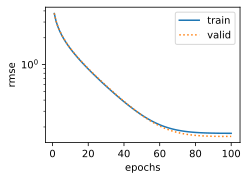

fold 0, train rmse 0.169719, valid rmse 0.156691
fold 1, train rmse 0.162057, valid rmse 0.189789
fold 2, train rmse 0.163465, valid rmse 0.167977
fold 3, train rmse 0.168044, valid rmse 0.154836
fold 4, train rmse 0.162356, valid rmse 0.182838
5-fold validation: avg train rmse 0.165128, avg valid rmse 0.170426


In [36]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size) 
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

有时候你会发现⼀组参数的训练误差可以达到很低，但是在$K$折交叉验证上的误差可能反而较⾼。这种现象很可能是由过拟合造成的。因此，当训练误差降低时，我们要观察$K$折交叉验证上的误差是否也相应降低。

### 3.16.7 预测并在Kaggle提交结果
下⾯定义预测函数。在预测之前，我们会使⽤完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式。

In [37]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net() 
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size) 
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse') 
    print('train rmse %f' % train_ls[-1]) 
    preds = net(test_features).asnumpy() 
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    # submission.to_csv('submission.csv', index=False)

设计好模型并调好超参数之后，下⼀步就是对测试数据集上的房屋样本做价格预测。如果我们得到与交叉验证时差不多的训练误差，那么这个结果很可能是理想的，可以在Kaggle上提交结果。

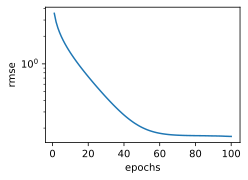

train rmse 0.162434


In [38]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)